# Project 1: Customer Database
**This is the first of three mandatory projects to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

#### Practical info
- **The project is to be done in groups of at most 3 students**
- **Each group has to hand in _one_ Jupyter notebook (this notebook) with their solution**
- **The hand-in of the notebook is due 2019-10-13, 23:59 on DTU Inside**

#### Your solution
- **Your solution should be in Python**
- **For each question you may use as many cells for your solution as you like**
- **You should document your solution and explain the choices you've made (for example by using multiple cells and use Markdown to assist the reader of the notebook)**
- **You should not remove the problem statements, and you should not modify the structure of the notebook**
- **Your notebook should be runnable, i.e., clicking [>>] in Jupyter should generate the result that you want to be assessed**
- **You are not expected to use machine learning to solve any of the exercises**
- **You will be assessed according to correctness and readability of your code, choice of solution, choice of tools and libraries, and documentation of your solution**

## Introduction
Your team has been hired by the company X as data scientists. X makes gadgets for a wide range of industrial and commercial clients.

As in-house data scientists, your teams first task, as per request from your new boss, is to optimize business operations. You have decided that a good first step would be to analyze the companys historical sales data to gain a better understanding of where profit is coming from. It may also reveal some low hanging fruit in terms of business opportunities.

To get started, you have called the IT department to get access to the customer and sales transactions database. To your horror you've been told that such a database doens't exist, and the only record of sales transactions is kept by John from finance in an Excel spreadsheet. So you've emailed John asking for a CSV dump of the spreadsheet...

In this project you need to clean the data you got from John, enrich it with further data, prepare a database for the data, and do some data analysis. The project is comprised of five parts. They are intended to be solved in the order they appear, but it is highly recommended that you read through all of them and devise an overall strategy before you start implementing anything.

## Part 1: Cleaning the data
John has emailed you the following link to the CSV dump you requested.

- [transactions.csv](https://raw.githubusercontent.com/patrickcording/02807-comp-tools/master/docker/work/data/transactions.csv)

It seems as though he has been a bit sloppy when keeping the records. 

In this part you should:
- Explain what the data is
- Clean it to prepare it for inserting into a database and doing data analysis 

---
### Solution

We start off by fetching the data, checking the data types and the first few lines to get a general feeling for what we are working with.

In [8]:
import pandas as pd
import numpy as np

df = pd.read_csv('transactions.csv')

print(df.dtypes)

df.head()

part       object
company    object
country    object
city       object
price      object
date       object
dtype: object


,part,company,country,city,price,date
0,54868-5165,Chatterbridge,Spain,Barcelona,784.79€,2016-01-02 00:01:05
1,60505-2867,Lajo,Greece,Thessaloniki,187.99€,2016-01-02 00:05:26
2,24385-268,Flipstorm,Greece,Athens,221.73€,2016-01-02 00:18:30
3,76117-001,Twitterbeat,France,Annecy,1075.82€,2016-01-02 02:32:30
4,44946-1046,Chatterbridge,Spain,Barcelona,412.55€,2016-01-02 04:51:55


The data consists of:
- Part serial number
- Company name
- Company location, country
- Company location, city
- Price of the part
- Date of transaction

In [53]:
print('number of rows: ', len(df), '\n')
print('unique parts: ', len(df.part.unique()))
print('nan: ', df.part.isna().sum(), '\n')

print(df.country.unique())
print('nan: ', df.country.isna().sum(), '\n')

print(df.city.unique())
print('nan: ', df.city.isna().sum(), '\n')

print('price nan: ', df.price.isna().sum())

number of rows:  20568 

unique parts:  101
nan:  10 

['Spain' 'Greece' 'France' 'Germany' 'United Kingdom' 'Portugal'
 'United States' 'Netherlands' 'Japan' 'Switzerland' nan 'US' 'Tyskland'
 'Portuga']
nan:  2171 

['Barcelona' 'Thessaloniki' 'Athens' 'Annecy' 'Paris' 'Düsseldorf'
 'London' 'Braga' 'Nanterre' 'Amadora\t' 'New York' 'Arnhem' 'Nice'
 'Lisbon' 'Amsterdam' 'Porto' 'Boston' 'Niihama' 'Almada' 'Aranhas'
 'Heraklion' 'Amiens' 'Patras' 'Arcueil' 'Lyon' 'Asaka' 'Champagnole'
 'Zürich' nan 'Monção' 'Vila Fria']
nan:  33 

price nan:  1


In [41]:
df.query('country == city')

,part,company,country,city,price,date


country
France            3463
Germany           1125
Greece            1630
Japan              159
Netherlands        427
Portuga              5
Portugal          7383
Spain             1425
Switzerland         11
Tyskland             1
US                   1
United Kingdom    1511
United States     1256
Name: country, dtype: int64

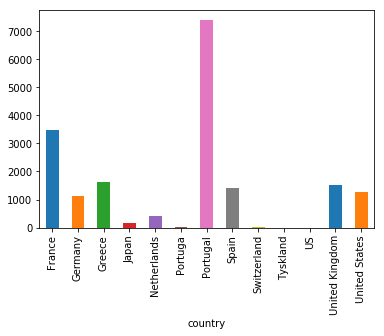

In [36]:
target_data = df.groupby('country')['country'].count()
target_data.plot(kind='bar')
target_data

city
Almada           357
Amadora\t       2787
Amiens           498
Amsterdam         44
Annecy          2267
Aranhas          627
Arcueil          204
Arnhem           426
Asaka             54
Athens           812
Barcelona       1589
Boston           454
Braga           1237
Champagnole       36
Düsseldorf      1254
Heraklion        151
Lisbon          1667
London          1669
Lyon              27
Monção             1
Nanterre         381
New York         968
Nice             212
Niihama          126
Paris            250
Patras           653
Porto           1550
Thessaloniki     221
Vila Fria          1
Zürich            12
Name: city, dtype: int64

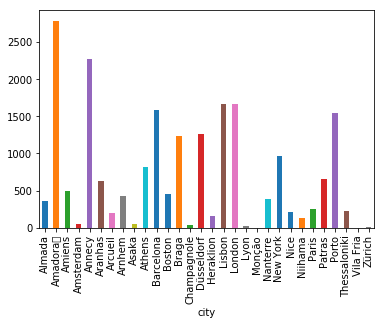

In [37]:
target_data = df.groupby('city')['city'].count()
target_data.plot(kind='bar')
target_data

---
## Part 2: Enriching the data

A common task for a data scientists is to combine or enrich data from internal sources with data available from external sources. The purpose of this can be either to fix issues with the data or to make it easier to derive insights from the data.

In this part you should enrich your data with data from at least one external source. You may look to part 4 for some  inspiration as to what is required. Your solution should be automated, i.e., you can not ask the reader of your notebook to download any data manually. You should argue why and what you expect to achieve by the enrichments you are doing.

---
### Solution

In [ ]:
# Any ideas? Include also price in currency of the company's country in order to see if profits are down because
# of unfavorable exchange rate or possibly some other cause?
# Or maybe it's just enough to find out how much inflation has changed the value since the transaction was made so that we
# have a better idea of whether profits are really dropping?

---
## Part 3: Creating a database
Storing data in a relational database has the advantages that it is persistent, fast to query, and it will be easier access for other employees at Weyland-Yutani.

In this part you should:
- Create a database and table(s) for the data
- Insert data into the tables

You may use SQLite locally to do this. You should argue why you choose to store your data the way you do. 

---
### Solution

In [ ]:
# TODO: Explain

In [26]:
import sqlite3
conn = sqlite3.connect('project1.sqlite')
c = conn.cursor()

c.execute('DROP TABLE IF EXISTS trans')
conn.commit()
c.execute('DROP TABLE IF EXISTS part')
conn.commit()
c.execute('DROP TABLE IF EXISTS city')
conn.commit()
c.execute('DROP TABLE IF EXISTS country')
conn.commit()
c.execute('DROP TABLE IF EXISTS price')
conn.commit()

In [27]:
query = '''
CREATE TABLE IF NOT EXISTS trans(
    id INTEGER PRIMARY KEY,
    part_id INTEGER,
    city_id INTEGER,
    price_id INTEGER,
    transaction_date DATETIME,
    FOREIGN KEY(part_id) REFERENCES part(id),
    FOREIGN KEY(city_id) REFERENCES city(id),
    FOREIGN KEY(price_id) REFERENCES price(id)
)
'''

c.execute('CREATE TABLE IF NOT EXISTS part(id INTEGER PRIMARY KEY, serial VARCHAR(50))')
conn.commit()

c.execute('CREATE TABLE IF NOT EXISTS country(id INTEGER PRIMARY KEY, name VARCHAR(50))')
conn.commit()

query = '''
CREATE TABLE IF NOT EXISTS city(
    id INTEGER PRIMARY KEY,
    country_id INTEGER,
    name VARCHAR(50),
    FOREIGN KEY(country_id) REFERENCES country(id)
)
'''
c.execute(query)
conn.commit()

# need to figure out what to put here
c.execute('CREATE TABLE IF NOT EXISTS price(id INTEGER PRIMARY KEY, amount DECIMAL(13, 4))')
conn.commit()

---
## Part 4: Analyzing the data
You are now ready to analyze the data. Your goal is to gain some actionable business insights to present to your boss. 

In this part, you should ask some questions and try to answer them based on the data. You should write SQL queries to retrieve the data. For each question, you should state why it is relevant and what you expect to find.

To get you started, you should prepare answers to the following questions. You should add more questions.
#### Who are the most profitable clients?
Knowing which clients that generate the most revenue for the company will assist your boss in distributing customer service ressources.

#### Are there any clients for which profit is declining?
Declining profit from a specific client may indicate that the client is disatisfied with the product. Gaining a new client is often much more work than retaining one. Early warnings about declining profit may help your boss fighting customer churn.


Remember, you are taking this to your new boss, so think about how you present the data.

---
### Solution

---
## Part 5: Performance
Your boss is very impressed with what you have achieved in less than two weeks, and he would like to take your idea of storing the customer and sales data in a relational database to production. However, John is concerned that the solution will not scale. His experience is telling him that you will see many occurrences of the following queries.

- Show all sales to company X between time $t_1$ and time $t_2$
- Show the latest X sales in the database
- Show total sales per company per day

Show that Johns concern is not justified.

---
### Solution

In [ ]:
# Concerns of a massive and therefore slow database? Fix with indexes?

---